# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-da0e45b5-9bf9-8fbc-6eba-60b6bc6c0f06)


In [ ]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2014-11-04_2022-01-01-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2616 entries, 2014-11-04 to 2022-01-01
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2616 non-null   object 
 1   Closing Price (USD)  2616 non-null   float64
 2   24h Open (USD)       2616 non-null   float64
 3   24h High (USD)       2616 non-null   float64
 4   24h Low (USD)        2616 non-null   float64
dtypes: float64(4), object(1)
memory usage: 122.6+ KB


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-12-28,BTC,50696.802160,50792.240989,52061.640000,50480.20
2021-12-29,BTC,47535.309698,50696.802023,50709.972512,47318.93
2021-12-30,BTC,46471.230000,47535.919464,48130.998494,46120.00
2021-12-31,BTC,47128.468155,46471.240000,47912.301142,45991.21
2022-01-01,BTC,46208.210437,47127.968178,48570.092839,45663.35


In [ ]:
len(df)

2616

We've collected the historical price of bitcoin for past 7years and 4 months with only 2616 samples.

Typically, deep learning loves millions of samples of data.

However, a small data sample is something you always run into with time series forecasting/classification data.

> **NOTE:** The seasonality of a time series dataset is the number of samples generated per year. Our bitcoin dataset has a seasonality of daily with a value of 365 as we collect data once a day.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)" : "Price"})
bitcoin_prices

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2021-12-28,50696.802160
2021-12-29,47535.309698
2021-12-30,46471.230000


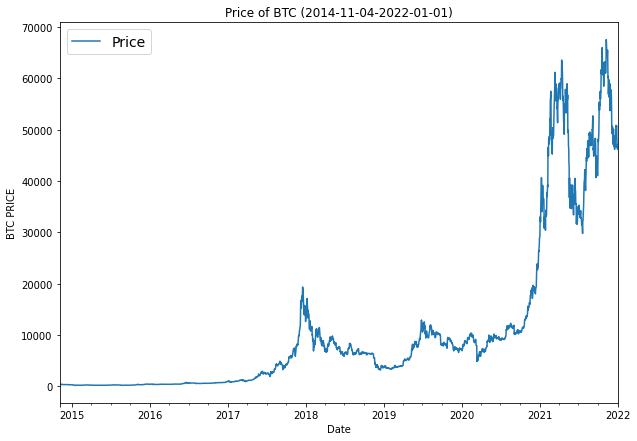

In [ ]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize = (10,7))
plt.ylabel("BTC PRICE")
plt.title("Price of BTC (2014-11-04-2022-01-01)")
plt.legend(fontsize = 14)

## Format Data Part 1: Creatining train and test sets for time series data

* **Univariate** time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

### Creating train and test sets with time series data (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10] , prices[:10]

(array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]))

In [ ]:
# The wrong way
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2092,), (524,), (2092,), (524,))

Text(0, 0.5, 'BTC PRICE')

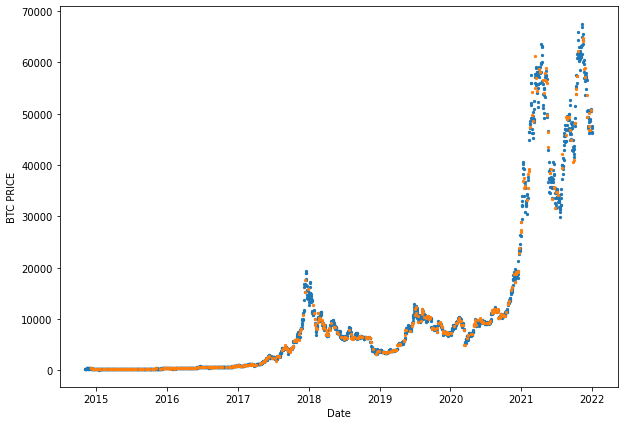

In [ ]:
# Lets plot wrongly
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s =5, label ="Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC PRICE")

### Create train and test sets for time series(the right way)

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2014-11-04_2022-01-01-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0),
  datetime.datetime(2014, 11, 13, 0, 0)],
 [324.467934,
  328.644408,
  337.921358,
  348.99286,
  341.459753,
  344.745289,
  357.239982,
  371.116917,
  366.664633,
  428.882925])

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2092, 524, 2092, 524)

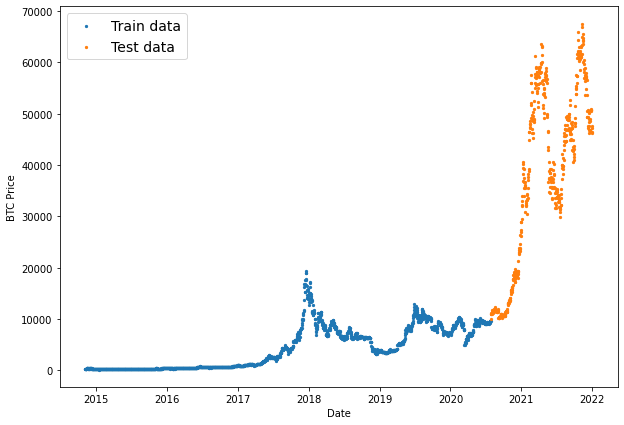

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [ ]:
def plot_time_series(timesteps, values, format = '.', start = 0, end = None, label = None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

NameError: ignored

<Figure size 720x504 with 0 Axes>

## Modelling Experiments

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

Experiments we are running (Horizon/Window)

0. Naïve model (baseline)
2. Dense model 1/7
3. Same as 1 1/30
4. Same as 1 7/30
5. Conv1D 1/7
6. LSTM 1/7
7. Same as 1 with multivariate 1/7
8. N-Beats 1/7
9. Ensemble (multiple models optimized on different loss functions) 1/7
10. Future prediction model (model to predict future values) 1/7
10. Same as 1 (but with turkey 🦃 data introduced) 1/7


## Model 0 : Naïve Baseline Forecast


The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

>The prediction at timestep t(y-hat) is equal to the prediction at timestep t-1(y)

In [ ]:
# Create a naīve forecast

naive_forecast = y_test[:-1]

naive_forecast[:10] , naive_forecast[-10:]

(array([ 9940.53292 , 11045.5     , 10933.5     , 11110.779249,
        11112.39206 , 11351.67    , 11816.057687, 11065.305792,
        11237.354858, 11194.363266]),
 array([48921.134112, 48610.619112, 50807.      , 50834.3     ,
        50430.073507, 50792.036921, 50696.80216 , 47535.309698,
        46471.23    , 47128.468155]))

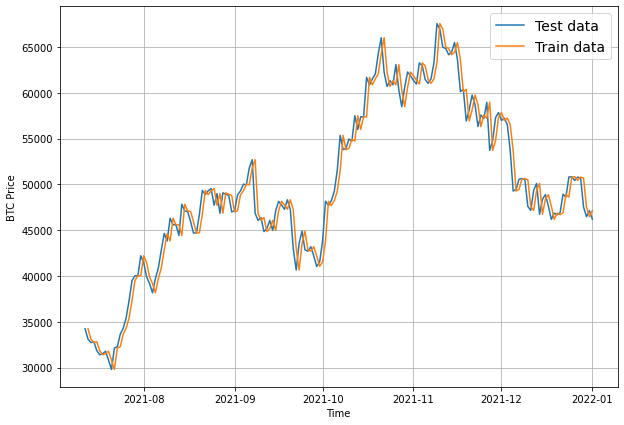

In [ ]:
# Plot naive forecast
plt.figure(figsize = (10,7))
plot_time_series(X_test, y_test, start=350, format = "-", label = "Test data")
plot_time_series(X_test[1:],naive_forecast, start= 350, format = "-", label = "Train data")

## Evaluating a time series model

Since we are predicting a number- its a regression problem.

Since we are working on regression, we'll use regression alike metrics like `mae` or `mse`

In [ ]:
import tensorflow as tf

# MASE IMPLEMENTATION

def mean_absolute_scaled_error(y_true, y_preds):
  """
  Implementation MASE (no seasonality)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_preds))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae/ mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.999999880809088

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

In [ ]:
naive_forecast[-10:]

array([48921.134112, 48610.619112, 50807.      , 50834.3     ,
       50430.073507, 50792.036921, 50696.80216 , 47535.309698,
       46471.23    , 47128.468155])

## Format Data Part 2 : Windowing our dataset

We window our time series dataset to turn data into a supervised learning problem

```
[0,1,2,3,4,5,6]->[7]
[1,2,3,4,5,6,7]->[8]
[2,3,4,5,6,7,8]->[9]
```

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
import tensorflow as tf
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We could use a python for loop for this, but since our data is huge we'll use numpy array data indexing instead.

Our function will
1. Create a window step of specific window size eg: `[0,1,2,3,4,5,6]`
2. Use NumPy indexing to create a 2D array of multiple window steps
```
[[0,1,2,3,4,5,6]
[0,1,2,3,4,5,6]
[2,3,4,5,6,7,8]]
```
3. Uses the 2D array of multiple window steps to index of a target series
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with specified horizons

In [ ]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2609, 2609)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] -> Label: [371.116917] 
Window: [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] -> Label: [366.664633] 
Window: [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] -> Label: [428.882925] 


In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [48610.619112 50807.       50834.3      50430.073507 50792.036921
 50696.80216  47535.309698] -> Label: [46471.23] 
Window: [50807.       50834.3      50430.073507 50792.036921 50696.80216
 47535.309698 46471.23    ] -> Label: [47128.468155] 
Window: [50834.3      50430.073507 50792.036921 50696.80216  47535.309698
 46471.23     47128.468155] -> Label: [46208.210437] 


### Turning windows into training and test sets

In [ ]:
def make_train_test_splits(windows, labels, test_split = 0.2):


  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2087, 522, 2087, 522)

In [ ]:
train_windows[:5], train_labels[:5]


(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218]]), array([[371.116917],
        [366.664633],
        [428.882925],
        [418.944218],
        [399.688315]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare them.

We will compare model performance on the best epoch of all models.

In [ ]:
import os 

# Create a function to implement a ModelCheckpoint callback with a specific filename
def checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbosity = 0,
                                            save_best_only = True)

## Model 1 : Dense Model (window=7, horizon=1)

Our first deep model is going to be a simple dense model and is going to have the following parameters:
1. A single dense layer with 128 hidden units and ReLu activation.
2. An output layer with linear none activation.
3. Adam optimization and MAE loss function.
4. Batch size of 128
5. Run for a 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# 1. Construct a model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation = "relu"),
  layers.Dense(HORIZON, activation = "linear")
], name = "model_1_dense")

# 2. Compile
model_1.compile(loss ="mae",
                optimizer = "Adam",
                metrics = ["mae","mse"])

# 3. Fit
model_1.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [checkpoint(model_name = model_1.name)])

Epoch 1/100
17/17 [==============================] - 1s 61ms/step - loss: 1080.3765 - mae: 1080.3765 - mse: 3381623.5000 - val_loss: 4789.9209 - val_mae: 4789.9209 - val_mse: 35937696.0000
Epoch 2/100
17/17 [==============================] - 1s 39ms/step - loss: 347.4058 - mae: 347.4058 - mse: 384801.0312 - val_loss: 1911.1986 - val_mae: 1911.1986 - val_mse: 7077476.0000
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 256.7753 - mae: 256.7753 - mse: 245706.4688 - val_loss: 1931.0428 - val_mae: 1931.0428 - val_mse: 6864009.0000
Epoch 4/100
17/17 [==============================] - 1s 40ms/step - loss: 223.1012 - mae: 223.1012 - mse: 197263.1094 - val_loss: 1728.9010 - val_mae: 1728.9010 - val_mse: 6039650.5000
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 210.6113 - mae: 210.6113 - mse: 185581.3281 - val_loss: 1683.4125 - val_mae: 1683.4125 - val_mse: 5493730.0000
Epoch 6/100
17/17 [==============================] - 1s 38ms/step - loss

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)


17/17 [==============================] - 0s 3ms/step - loss: 1154.0116 - mae: 1154.0116 - mse: 2799967.5000


[1154.0115966796875, 1154.0115966796875, 2799967.5]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test_data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)


17/17 [==============================] - 0s 3ms/step - loss: 1112.2589 - mae: 1112.2589 - mse: 2711870.2500


[1112.2589111328125, 1112.2589111328125, 2711870.25]

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

## Making forcasts with a model (on test datasets)

1. Take in a trained model
2. Takes in some input data of the kind upon which it was trained on.
3. Passes the input data to the model's `predict()`
4. Returns the predictions


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

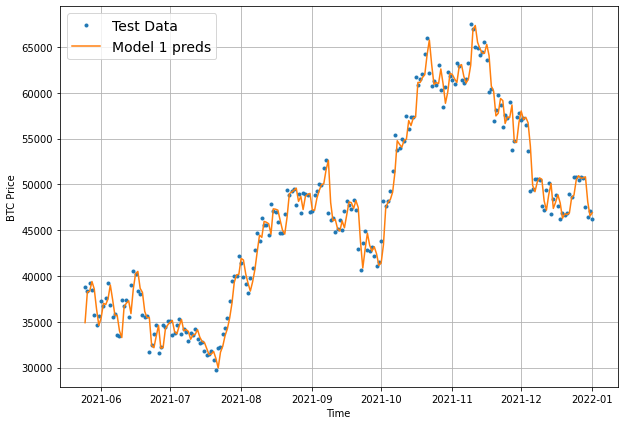

In [ ]:
# Lets plot our model 1 predictions
offset = 300
plt.figure(figsize = (10,7))
# Account for offset by indexing
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 start = offset,
                 label = "Test Data")

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_1_preds,
                 start = offset,
                 format = "-",
                 label = "Model 1 preds")

## MODEL 2 : DENSE (window = 30, horizon =1 )

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30


In [ ]:
# Make windowed data with appropriate horizons and window sizes
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2586, 2586)

In [ ]:
# make test and train labels
train_windows, test_windows, train_labels, test_labels= make_train_test_splits(windows=full_windows,
                                                                               labels = full_labels,
                                                                               test_split = 0.2)

In [ ]:
train_windows[:3] , train_labels[:3]

(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
         418.944218, 399.688315, 374.983975, 388.040069, 387.062731,
         373.7797  , 378.013084, 356.750538, 350.599464, 352.080105,
         366.424325, 376.211826, 376.917086, 369.402421, 369.807768,
         377.078294, 375.964613, 377.568288, 380.535819, 382.810282],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917, 366.664633, 428.882925, 418.944218,
         399.688315, 374.983975, 388.040069, 387.062731, 373.7797  ,
         378.013084, 356.750538, 350.599464, 352.080105, 366.424325,
         376.211826, 376.917086, 369.402421, 369.807768, 377.078294,
         375.964613, 377.568288, 380.535819, 382.810282, 376.230628],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633, 428.882925, 418.944218, 399.688315,
         374.983975, 388.040069,

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation = "relu"),
  layers.Dense(HORIZON)                               
], name = "model_2_dense")

model_2.compile(loss = "mae",
                optimizer = "Adam")

history_2 = model_2.fit(train_windows,
                        train_labels,
                        epochs = 100,
                        verbose = 0,
                        batch_size = 128,
                        validation_data = (test_windows, test_labels),
                        callbacks = [checkpoint(model_name = model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
# Evaluate model 2 on test data
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(test_windows,test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1179.2028


1179.2027587890625

In [ ]:
model_2_preds = make_preds(model_2, test_windows)
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 1179.2028,
 'mape': 3.0054307,
 'mase': 1.0587211,
 'mse': 2935542.5,
 'rmse': 1713.3425}

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

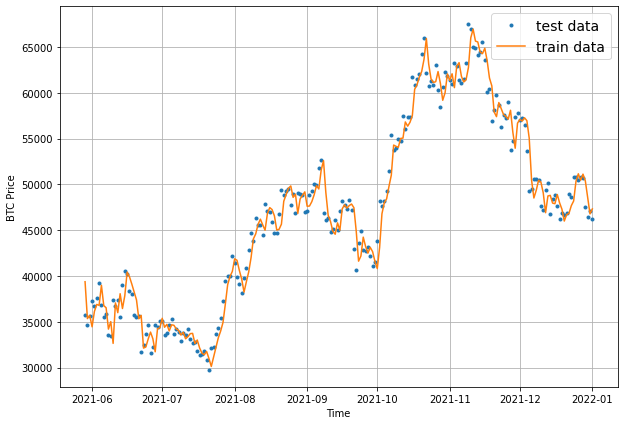

In [ ]:
offset = 300
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 start = offset,
                 label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_2_preds,
                 start = offset,
                 format = "-",
                 label = "train data")

## MODEL 3 : DENSE (WINDOW = 30 , HORIZON = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)

In [ ]:
len(full_windows), len(full_labels)

(2580, 2580)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)

In [ ]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2064, 2064, 516, 516)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation = "relu"),
                               layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss = "mae",
                optimizer = "Adam")
model_3.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 2457.5403


2457.540283203125

In [ ]:
# Load in best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
# Evaluate results for model 2 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  701.3588 ,   358.51578,   249.38867,   243.80566,   295.85016,
          302.14508,   200.5883 ,   216.56139,   376.98843,   162.44572,
          172.01506,   169.80734,   198.20187,   122.25572,   217.69727,
          194.79813,   245.3319 ,   187.58775,   176.10938,   233.84877,
          239.18541,   301.3605 ,   444.42465,   329.9555 ,   289.80328,
          194.01994,   225.49484,   333.03348,   230.9601 ,    97.92509,
          267.67117,   405.14914,   525.3626 ,   664.9644 ,   835.7966 ,
         1061.2697 ,  1457.0636 ,  1382.3185 ,   524.84515,   333.5081 ,
          179.59277,   214.21037,   166.80148,   316.98285,   431.05887,
          488.26367,   492.40082,   455.64215,   450.4163 ,   395.17215,
          247.7758 ,   252.0219 ,   353.6639 ,   284.19672,   443.52164,
          359.82715,   232.58105,   191.58678,   334.6688 ,   185.20242,
          177.63197,   141.09612,   242.84375,   135.30008,   179.1649 ,
          215.39565,   153.15652,   121.8791

## Make our evaluation for a larger horizon

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 2335.471,
 'mape': 5.946342,
 'mase': 2.1002116,
 'mse': 11564274.0,
 'rmse': 2674.5078}

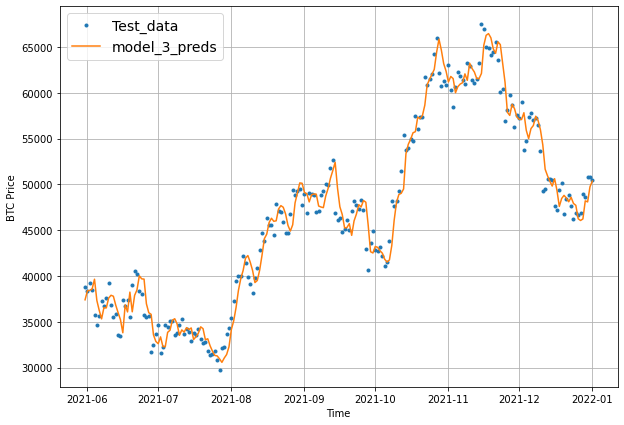

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis =1), format="-", start=offset, label="model_3_preds")

## Which of our models are performing the best so far?

We've trained a few models, now lets compare them and see how they've gone


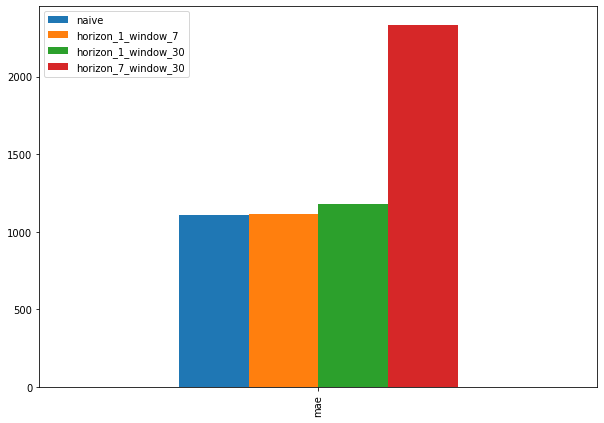

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4 : Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create a windowed dataset 
full_windows, full_labels = make_windows(prices,
                                         window_size = WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows),len(full_labels)

(2609, 2609)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels,
    test_split = 0.2
)

In [ ]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2087, 522, 2087, 522)

To use Conv1D layer we need as input shape of : `(batch_size, timesteps, input_dim)`

However our data isn't in that shape so far....

In [ ]:
# check the data input shape
train_windows[0].shape

(7,)

In [ ]:
# before we pass our data to the conv1d layer, we must reshape it
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis =1))

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[324.46793]
 [328.6444 ]
 [337.92136]
 [348.99286]
 [341.45975]
 [344.7453 ]
 [357.24   ]]


In [ ]:
# Create the model finally

tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x : tf.expand_dims(x, axis = 1)),
  layers.Conv1D(128, kernel_size = 5, padding = "causal", activation = "relu"),
  layers.Dense(HORIZON)
], name = "model_4_conv1d")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[checkpoint(model_name=model_4.name)])


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1d/assets
INFO:tensorflow:Assets wr

In [ ]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 5ms/step - loss: 1142.2242


1142.2242431640625

In [ ]:
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 4ms/step - loss: 1115.8798


1115.8797607421875

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

In [ ]:
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 1115.8798,
 'mape': 2.839977,
 'mase': 1.0080743,
 'mse': 2735737.0,
 'rmse': 1654.0063}

In [ ]:
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

## Model 5 : RNN - LSTM

Let's build an RNN model for our time series data and we'll use the same data which we used previously. 

In [ ]:
train_windows[:5]

array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982],
       [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
        357.239982, 371.116917],
       [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
        371.116917, 366.664633],
       [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
        366.664633, 428.882925],
       [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
        428.882925, 418.944218]])

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x, axis = 1))(inputs)
#x = layers.LSTM(128, return_sequences = True)(x)
x = layers.LSTM(128, activation = "relu")(x)
#x = layers.Dense(32, activation = "relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs , name = "model_5_LSTM")

# Compile
model_5.compile(loss = "mae",
                optimizer = "Adam")

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [checkpoint(model_name = model_5.name)])

Epoch 1/100
15/17 [=========================>....] - ETA: 0s - loss: 3341.6499INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 7s 306ms/step - loss: 3266.6018 - val_loss: 19408.2324
Epoch 2/100
16/17 [===========================>..] - ETA: 0s - loss: 1356.2211INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 325ms/step - loss: 1339.8540 - val_loss: 2605.6687
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 339.0145INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 280ms/step - loss: 339.0145 - val_loss: 1801.9974
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 243.8647 - val_loss: 1844.7241
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 229.4398 - val_loss: 1858.4532
Epoch 6/100
14/17 [=======================>......] - ETA: 0s - loss: 216.3915INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 277ms/step - loss: 220.1644 - val_loss: 1788.2474
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 218.1684 - val_loss: 1788.3770
Epoch 8/100
17/17 [==============================] - ETA: 0s - loss: 216.5959INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 285ms/step - loss: 216.5959 - val_loss: 1770.1074
Epoch 9/100
17/17 [==============================] - 0s 18ms/step - loss: 215.5635 - val_loss: 1770.2234
Epoch 10/100
17/17 [==============================] - ETA: 0s - loss: 214.0159INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 322ms/step - loss: 214.0159 - val_loss: 1737.4209
Epoch 11/100
15/17 [=========================>....] - ETA: 0s - loss: 210.1921INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 283ms/step - loss: 212.6667 - val_loss: 1723.9016
Epoch 12/100
17/17 [==============================] - 0s 15ms/step - loss: 210.7815 - val_loss: 1740.2880
Epoch 13/100
16/17 [===========================>..] - ETA: 0s - loss: 209.7871INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 284ms/step - loss: 209.1857 - val_loss: 1702.0363
Epoch 14/100
16/17 [===========================>..] - ETA: 0s - loss: 208.5044INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 312ms/step - loss: 207.5939 - val_loss: 1691.8276
Epoch 15/100
17/17 [==============================] - 0s 20ms/step - loss: 204.7518 - val_loss: 1693.3845
Epoch 16/100
15/17 [=========================>....] - ETA: 0s - loss: 200.7645INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 280ms/step - loss: 203.0015 - val_loss: 1649.9044
Epoch 17/100
16/17 [===========================>..] - ETA: 0s - loss: 202.5701INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 286ms/step - loss: 201.4809 - val_loss: 1642.0032
Epoch 18/100
17/17 [==============================] - ETA: 0s - loss: 198.5458INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 275ms/step - loss: 198.5458 - val_loss: 1619.5024
Epoch 19/100
14/17 [=======================>......] - ETA: 0s - loss: 194.6904INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 316ms/step - loss: 196.6174 - val_loss: 1606.8521
Epoch 20/100
13/17 [=====================>........] - ETA: 0s - loss: 195.5233INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 278ms/step - loss: 195.0635 - val_loss: 1601.8149
Epoch 21/100
17/17 [==============================] - 0s 15ms/step - loss: 193.1684 - val_loss: 1609.8271
Epoch 22/100
17/17 [==============================] - 0s 14ms/step - loss: 195.8001 - val_loss: 1643.9988
Epoch 23/100
16/17 [===========================>..] - ETA: 0s - loss: 187.6527INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 283ms/step - loss: 187.7156 - val_loss: 1598.9417
Epoch 24/100
16/17 [===========================>..] - ETA: 0s - loss: 186.7643INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 335ms/step - loss: 187.1179 - val_loss: 1527.8656
Epoch 25/100
17/17 [==============================] - ETA: 0s - loss: 187.6975INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 338ms/step - loss: 187.6975 - val_loss: 1507.1317
Epoch 26/100
17/17 [==============================] - 0s 17ms/step - loss: 182.9133 - val_loss: 1547.7375
Epoch 27/100
17/17 [==============================] - 0s 14ms/step - loss: 180.5376 - val_loss: 1544.2164
Epoch 28/100
13/17 [=====================>........] - ETA: 0s - loss: 181.7445INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 335ms/step - loss: 179.0605 - val_loss: 1463.6221
Epoch 29/100
17/17 [==============================] - 0s 13ms/step - loss: 179.7611 - val_loss: 1469.6243
Epoch 30/100
17/17 [==============================] - 0s 17ms/step - loss: 174.9553 - val_loss: 1472.2386
Epoch 31/100
16/17 [===========================>..] - ETA: 0s - loss: 173.9440INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 289ms/step - loss: 173.0550 - val_loss: 1416.9398
Epoch 32/100
17/17 [==============================] - 0s 15ms/step - loss: 169.2865 - val_loss: 1460.1835
Epoch 33/100
17/17 [==============================] - ETA: 0s - loss: 168.3313INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 320ms/step - loss: 168.3313 - val_loss: 1388.2098
Epoch 34/100
17/17 [==============================] - 0s 19ms/step - loss: 167.6601 - val_loss: 1405.2225
Epoch 35/100
17/17 [==============================] - 0s 17ms/step - loss: 163.3183 - val_loss: 1390.6952
Epoch 36/100
17/17 [==============================] - ETA: 0s - loss: 161.7565INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 292ms/step - loss: 161.7565 - val_loss: 1350.6622
Epoch 37/100
17/17 [==============================] - 0s 18ms/step - loss: 160.8534 - val_loss: 1352.3354
Epoch 38/100
17/17 [==============================] - 0s 17ms/step - loss: 163.2776 - val_loss: 1432.4916
Epoch 39/100
15/17 [=========================>....] - ETA: 0s - loss: 163.0194INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 287ms/step - loss: 159.9959 - val_loss: 1343.5201
Epoch 40/100
17/17 [==============================] - 0s 19ms/step - loss: 158.5042 - val_loss: 1353.7085
Epoch 41/100
16/17 [===========================>..] - ETA: 0s - loss: 154.7922INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 290ms/step - loss: 156.4820 - val_loss: 1326.0616
Epoch 42/100
15/17 [=========================>....] - ETA: 0s - loss: 154.5970INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 328ms/step - loss: 157.7234 - val_loss: 1314.3241
Epoch 43/100
17/17 [==============================] - ETA: 0s - loss: 158.9388INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 292ms/step - loss: 158.9388 - val_loss: 1305.2191
Epoch 44/100
14/17 [=======================>......] - ETA: 0s - loss: 156.6080INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 285ms/step - loss: 157.6874 - val_loss: 1301.6168
Epoch 45/100
17/17 [==============================] - 0s 11ms/step - loss: 152.7335 - val_loss: 1329.6708
Epoch 46/100
16/17 [===========================>..] - ETA: 0s - loss: 155.1378INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 4s 280ms/step - loss: 155.0965 - val_loss: 1267.3672
Epoch 47/100
17/17 [==============================] - 0s 19ms/step - loss: 151.1288 - val_loss: 1268.4801
Epoch 48/100
16/17 [===========================>..] - ETA: 0s - loss: 149.6930INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 328ms/step - loss: 149.5797 - val_loss: 1258.4572
Epoch 49/100
17/17 [==============================] - 0s 15ms/step - loss: 149.0423 - val_loss: 1285.0750
Epoch 50/100
16/17 [===========================>..] - ETA: 0s - loss: 148.6815INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 286ms/step - loss: 149.5207 - val_loss: 1247.3384
Epoch 51/100
16/17 [===========================>..] - ETA: 0s - loss: 153.5786INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 6s 348ms/step - loss: 153.1578 - val_loss: 1245.4272
Epoch 52/100
16/17 [===========================>..] - ETA: 0s - loss: 151.5973INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 288ms/step - loss: 150.5272 - val_loss: 1238.8140
Epoch 53/100
17/17 [==============================] - 0s 18ms/step - loss: 153.7897 - val_loss: 1314.6575
Epoch 54/100
15/17 [=========================>....] - ETA: 0s - loss: 149.2333INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 320ms/step - loss: 147.8028 - val_loss: 1236.3898
Epoch 55/100
14/17 [=======================>......] - ETA: 0s - loss: 148.5174INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 284ms/step - loss: 146.3885 - val_loss: 1227.3365
Epoch 56/100
17/17 [==============================] - 0s 18ms/step - loss: 147.9531 - val_loss: 1258.3776
Epoch 57/100
15/17 [=========================>....] - ETA: 0s - loss: 149.5321INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 296ms/step - loss: 147.0709 - val_loss: 1221.7922
Epoch 58/100
17/17 [==============================] - 0s 16ms/step - loss: 145.5649 - val_loss: 1225.3138
Epoch 59/100
17/17 [==============================] - 0s 16ms/step - loss: 146.4210 - val_loss: 1237.2473
Epoch 60/100
16/17 [===========================>..] - ETA: 0s - loss: 144.7978INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 291ms/step - loss: 144.7848 - val_loss: 1211.0857
Epoch 61/100
13/17 [=====================>........] - ETA: 0s - loss: 143.0067INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 323ms/step - loss: 144.4642 - val_loss: 1210.1976
Epoch 62/100
17/17 [==============================] - 0s 19ms/step - loss: 146.8163 - val_loss: 1224.8751
Epoch 63/100
17/17 [==============================] - 0s 16ms/step - loss: 146.8148 - val_loss: 1234.4796
Epoch 64/100
17/17 [==============================] - ETA: 0s - loss: 145.7820INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 287ms/step - loss: 145.7820 - val_loss: 1209.6998
Epoch 65/100
14/17 [=======================>......] - ETA: 0s - loss: 148.7770INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 282ms/step - loss: 149.6701 - val_loss: 1200.4331
Epoch 66/100
17/17 [==============================] - 0s 20ms/step - loss: 144.7763 - val_loss: 1252.3286
Epoch 67/100
16/17 [===========================>..] - ETA: 0s - loss: 148.0532INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 320ms/step - loss: 148.1511 - val_loss: 1197.5573
Epoch 68/100
17/17 [==============================] - 0s 17ms/step - loss: 143.3920 - val_loss: 1227.4919
Epoch 69/100
17/17 [==============================] - 0s 19ms/step - loss: 148.1148 - val_loss: 1309.8710
Epoch 70/100
17/17 [==============================] - 0s 20ms/step - loss: 166.7706 - val_loss: 1318.8625
Epoch 71/100
17/17 [==============================] - 0s 14ms/step - loss: 155.3853 - val_loss: 1325.5269
Epoch 72/100
17/17 [==============================] - 0s 18ms/step - loss: 155.4531 - val_loss: 1335.3998
Epoch 73/100
17/17 [==============================] - 0s 19ms/step - loss: 153.7899 - val_loss: 1281.9791
Epoch 74/100
17/17 [==============================] - 0s 17ms/step - loss: 151.8372 - val_loss: 1297.2097
Epoch 75/100
17/17 [==============================] - 0s 18ms/step - loss: 151.0853 - val_loss: 1278.7262
Epoch 76/100
17/17 [==============================] - 0s 1

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 286ms/step - loss: 145.3342 - val_loss: 1189.1757
Epoch 95/100
17/17 [==============================] - ETA: 0s - loss: 142.6550INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 6s 351ms/step - loss: 142.6550 - val_loss: 1187.6344
Epoch 96/100
17/17 [==============================] - 0s 16ms/step - loss: 146.1743 - val_loss: 1298.2767
Epoch 97/100
16/17 [===========================>..] - ETA: 0s - loss: 147.5960INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 292ms/step - loss: 146.0518 - val_loss: 1187.3547
Epoch 98/100
17/17 [==============================] - 0s 20ms/step - loss: 140.8499 - val_loss: 1193.1505
Epoch 99/100
17/17 [==============================] - 0s 16ms/step - loss: 143.6575 - val_loss: 1196.0957
Epoch 100/100
15/17 [=========================>....] - ETA: 0s - loss: 141.4727INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 5s 322ms/step - loss: 140.7938 - val_loss: 1179.8011


In [ ]:
# Load in best model_5
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 6ms/step - loss: 1179.8011


1179.8011474609375

In [ ]:
model_5_preds = make_preds(model_5,test_windows)
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 1179.8011,
 'mape': 3.0076578,
 'mase': 1.0658202,
 'mse': 2940976.5,
 'rmse': 1714.9275}

In [ ]:
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

Building a neural networks algorithm doesn't necessarily mean that it will outperform all other models.

## Make a multivariate time series dataset

What feature should we add for prediction?

Whether elon musk tweeted on that day?

* Day 1 - 0
* Day 2 - 1
* Day 3 - 0



In [ ]:
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


In [ ]:
block_reward_2 = 25 # 8 Nov 2012
block_reward_3 = 12.5 # 9 july 2016
block_reward_4 = 6.25  # 18 may 2020

# Block neward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create data range
block_reward_2_days = (block_reward_3_datetime-bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime-bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days


(613, 2022)

In [ ]:
# Add in a column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward_values
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4


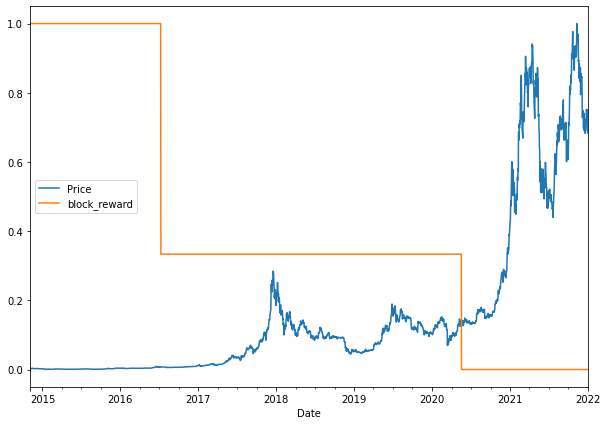

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` to make our multivariate dataframe work



In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columsn
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price + {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)
bitcoin_prices_windowed.head(10)

NameError: ignored

Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON
```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X windows and Y horizons feature
X = bitcoin_prices_windowed.dropna().drop("Price", axis =1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
X.head()

,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2014-11-11,25.0,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409,324.467926
2014-11-12,25.0,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409
2014-11-13,25.0,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356
2014-11-14,25.0,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859
2014-11-15,25.0,418.944214,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747


In [ ]:
y.head()

Date
2014-11-11    371.116913
2014-11-12    366.664642
2014-11-13    428.882935
2014-11-14    418.944214
2014-11-15    399.688324
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2087, 2087, 522, 522)

## Model 6 : Multivariate Dense Time-Series

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128, activation = "relu"),
  layers.Dense(HORIZON)
], name = "model_6_dense_multivariate")

model_6.compile(loss = "mae",
                optimizer = "Adam")

model_6.fit(X_train, y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (X_test, y_test),
            callbacks = [checkpoint(model_name = model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

17/17 [==============================] - 0s 5ms/step - loss: 1110.2162


1110.2161865234375

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 1110.2163,
 'mape': 2.8337274,
 'mase': 1.0029579,
 'mse': 2688908.2,
 'rmse': 1639.7891}

In [ ]:
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

## MODEL 7 : N-BEATS algorithm

lets now try to build the biggest time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in the following paper : https://arxiv.org/pdf/1905.10437.pdf

Why ?

* This will allow us to practice replicating a paper with tensorflow code
* We will see how to use tensorflow layer subclassing 
* Get experience using the functional API to create a custom architecture
* Create a state of the art model with exceptional results

### Building and test N-BEATs block layer

Because the N-Beats block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layersand model in TensorFlow, we can use subclassing:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def  __init__(self,
                input_size : int,
                theta_size : int,
                horizon : int,
                n_neurons : int,
                n_layers : int,
                **kwargs): # Takes care of arguments in parent class like input_shape etc
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block Contains stack of 4 fully connect layers each has relu activation
    self.hidden =[tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size,
                                             activation = "linear",
                                             name = "theta")
    
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size] , theta[:,-self.horizon:]

    return backcast, forecast



Lets test our NBeatsBlock Class.

To do so we'll make some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON,
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis = 0) # inputs shape to the model to reflect dense layer
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs into the block layer
backcast , forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activations outputs of the theta layers (they'll be random due to no training)

print(f"Backcast : {tf.squeeze(backcast.numpy())}")
print(f"Forecast : {tf.squeeze(forecast.numpy())}")

Backcast : [ 0.19014978  0.83798355 -0.32870018  0.25159916 -0.47540277 -0.77836645
 -0.5299447 ]
Forecast : -0.7554212808609009


### Preparing data for the N-Beats algorithm using `tf.data.`

To make our input data load as fast as possible then we're going to be adhering to the performant data pipeline steps in tf.data guide

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# create nbeats data inputs (N-beats works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


In [ ]:
# Add windowed columns 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-28,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112,48921.134112,46910.249593
2021-12-29,47535.309698,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112,48921.134112
2021-12-30,46471.230000,47535.309698,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis = 1)
y = bitcoin_prices_nbeats.dropna()["Price"]

ss = int(len(X)*0.8)
X_train, y_train = X[:ss] , y[:ss]
X_test, y_test = X[ss:] , y[ss:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2087, 522, 2087, 522)

In [ ]:
# Time to make our dataset performany
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_label_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_label_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_label_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_label_dataset))

# batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-Beats algorithm

The N-Beats algorithm has a fair few number of parameters, many of them found here in table 18 : https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE , THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-Beats model, we need to get our layers ready for residual connections. (substraction and addition)


In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting N-Beats Algorithm

1. Setup an instance of the N-beats block layer using `NBeatsBlock` , which will be the initial block used for the network with the rest being worked as a part of stacks
2. Create an input layer for the N-Beats stack which we will execute using Keras Functional API
3. Make the initial backcast and forecasts for the model with the layer created in __1__
4. Use `for` loop to create stack of block layers
5. We will use the `NBeatsBlock` class within the for loop __4__ to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using substract and add layers
7. Put them model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss. We'll use MAE To keep in accordance with the model along with Adam optimizer with default settings as described in the paper.
9. Fit the N-Beats model for 5000 epochs and since it's fitting for so many epochs we'll use a couple of callbacks:
  * Early Stopping - stops the model early if it overfits or stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce th amount by which it updates it's weights each time for increasing performance

In [ ]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])




Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00476: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 4min 4s, sys: 7.45 s, total: 4min 12s
Wall time: 5min 37s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 107ms/step - loss: 1130.8363 - mae: 1130.8363 - mse: 2763852.2500


[1130.8363037109375, 1130.8363037109375, 2763852.25]

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 1130.8363,
 'mape': 2.8969216,
 'mase': 1.0215858,
 'mse': 2763852.2,
 'rmse': 1662.4838}

In [ ]:
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

### Plotting the N-Beats architecture

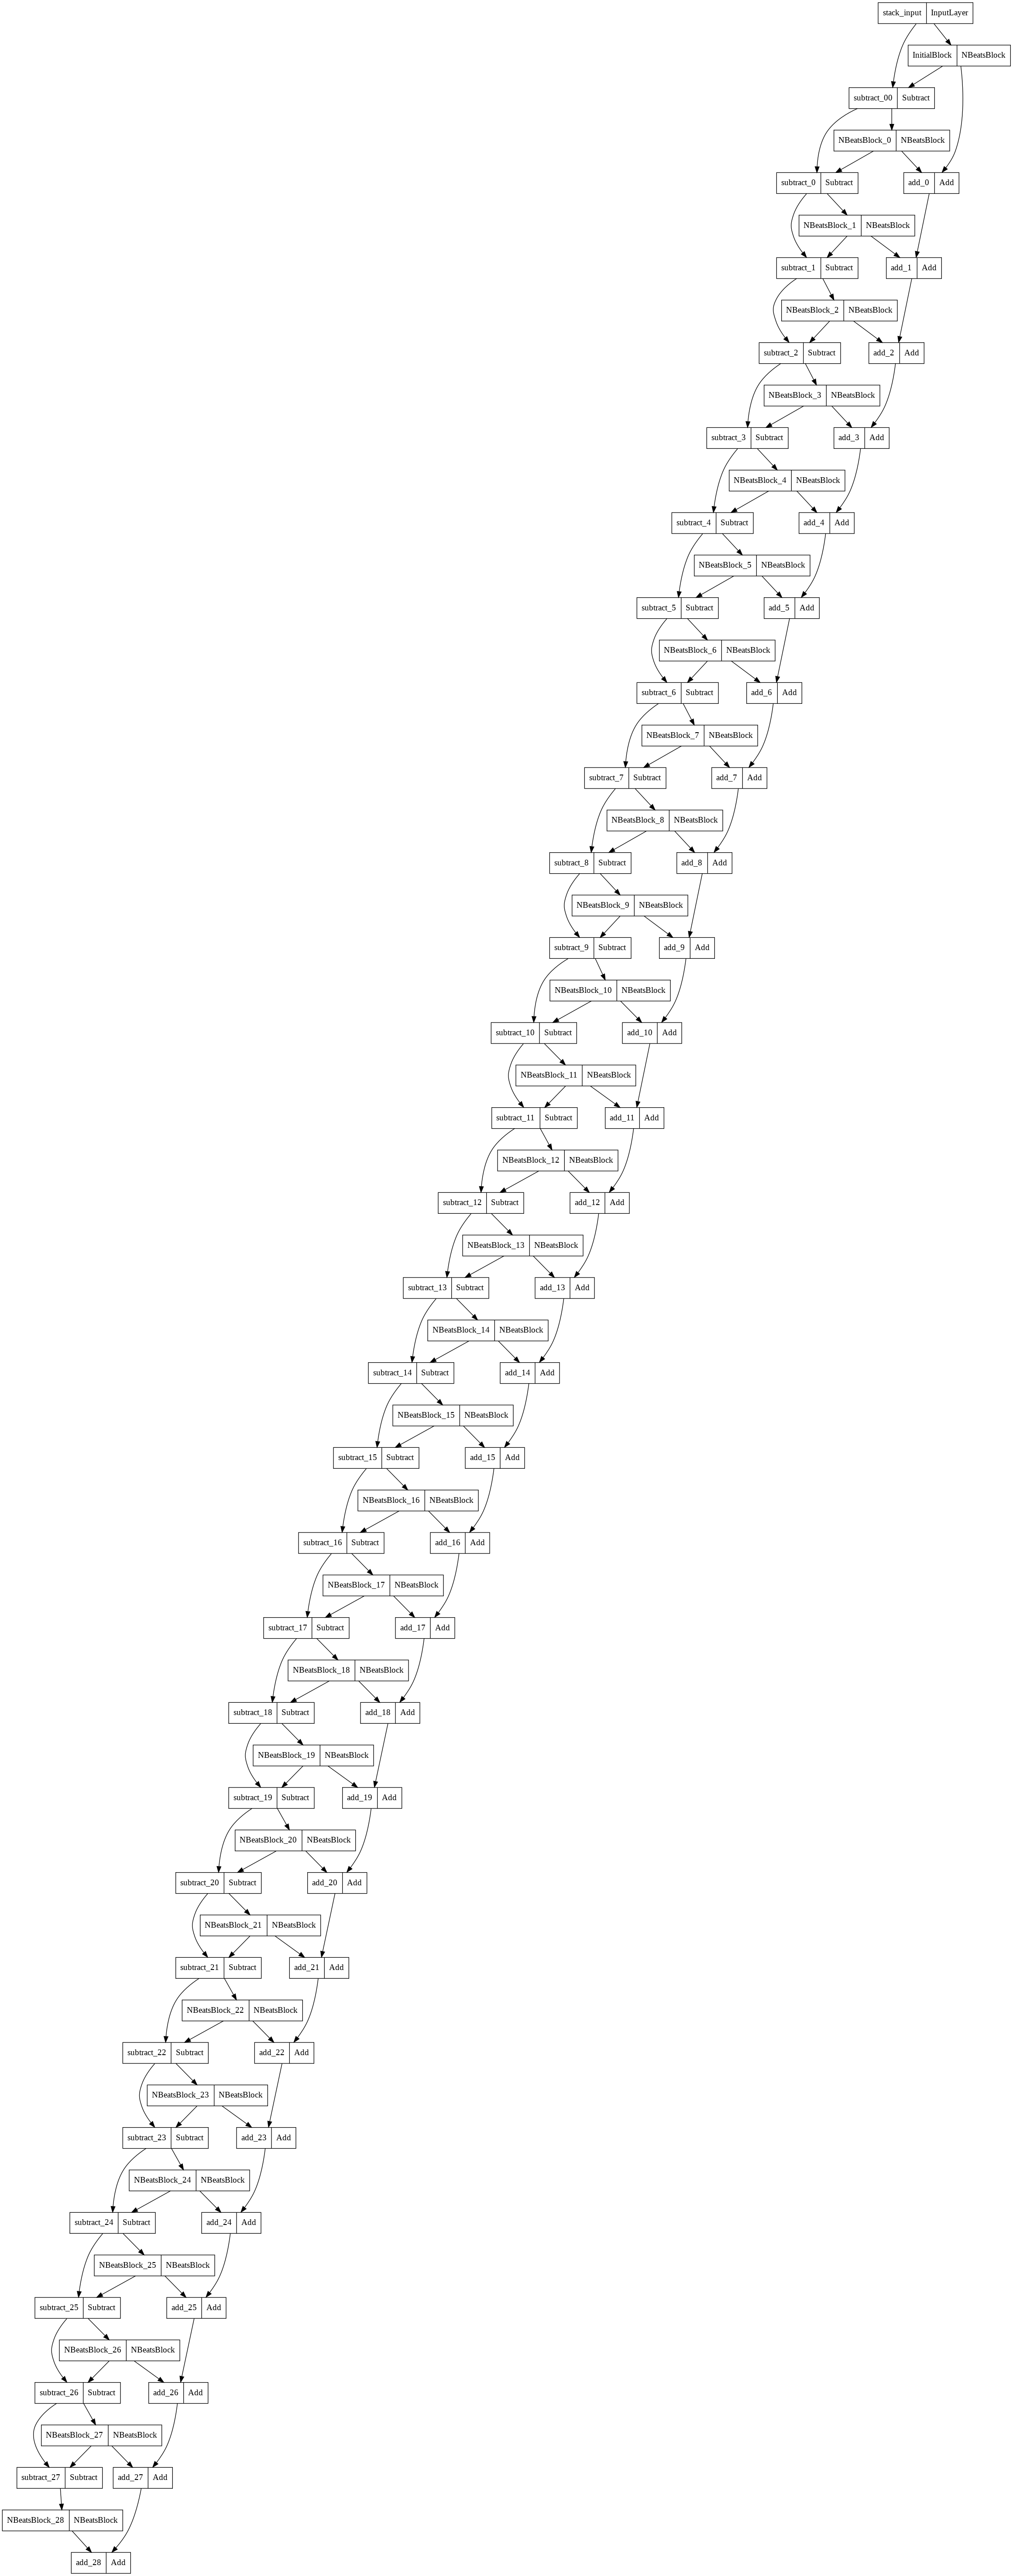

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
1+2


3

## Model 8 : create an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect, it combined many different models to predicts a common goal

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE,MSE & MAPE loss.

  For examples, if num_iter = 10, a list of 30 trained models will be returned
  10 * len(["mae","mse","mape"])
  """

  # Make emplty list for trained ensemble models
  ensemble_models = []

  # Create num_iter moders loss fn
  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing : {loss_function} for {num_epochs} epochs, model number : {i}")

      # Construct a simple model
      model = tf.keras.Sequential([
        layers.Dense(128,kernel_initializer = "he_normal", activation="relu"),
        layers.Dense(128,kernel_initializer = "he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(loss = loss_function,
                    optimizer = "Adam",
                    metrics = ["mae","mse"])
      
      # Fit on the data
      model.fit(train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data= test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience = 200,
                                                               restore_best_weights = True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      
      # lets append fitted model
      ensemble_models.append(model)
  
  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing : mae for 1000 epochs, model number : 0

Epoch 00671: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing : mse for 1000 epochs, model number : 0

Epoch 00632: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00732: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mape for 1000 epochs, model number : 0
Optimizing model by reducing : mae for 1000 epochs, model number : 1

Epoch 00351: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00595: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00695: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing : mse for 1000 epochs, model number : 1

Epoch 00288: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00413: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05

### Make predictions with our ensemble models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 1112.4951,
 'mape': 2.8440344,
 'mase': 1.0050166,
 'mse': 2701137.0,
 'rmse': 1643.5135}

In [ ]:
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

In [ ]:
model_1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

### Plotting the prediction intervals (uncertainity estimates)

Rather than a point value, we should instead have a range of predictions available to us instead.

To get a 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models.
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96, assuming a gaussian distrribution of data.
4. To get the prediciton interval upper and lower bounds, add and substract the value obtained in __1__ __&__ __3__

In [ ]:
# Find upper and lower bounds of ensemble predictions

def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis = 0)
  interval = 1.96*std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
get_upper_lower(ensemble_preds)

(<tf.Tensor: shape=(522,), dtype=float32, numpy=
 array([10808.425 , 10722.811 , 10937.047 , 11008.017 , 11201.674 ,
        11693.245 , 10905.513 , 11015.536 , 11013.383 , 11661.825 ,
        11577.208 , 11375.849 , 11649.284 , 11630.338 , 11817.401 ,
        11275.823 , 11425.791 , 11630.581 , 11661.433 , 11690.328 ,
        11764.368 , 12244.538 , 11856.348 , 11592.599 , 11706.577 ,
        11434.382 , 11533.84  , 11489.553 , 11661.265 , 11196.378 ,
        11306.863 , 11232.624 , 11458.561 , 11346.297 , 11568.685 ,
        11564.28  , 11827.396 , 11287.257 , 10086.769 , 10039.161 ,
         9943.757 , 10058.531 , 10011.943 ,  9889.26  , 10095.354 ,
        10229.229 , 10322.402 , 10333.084 , 10213.926 , 10600.19  ,
        10723.135 , 10860.806 , 10844.443 , 10843.826 , 11021.265 ,
        10848.29  , 10298.923 , 10346.606 , 10102.079 , 10571.544 ,
        10532.818 , 10545.081 , 10647.201 , 10595.949 , 10760.406 ,
        10697.733 , 10524.659 , 10474.284 , 10477.885 , 10608.905 ,

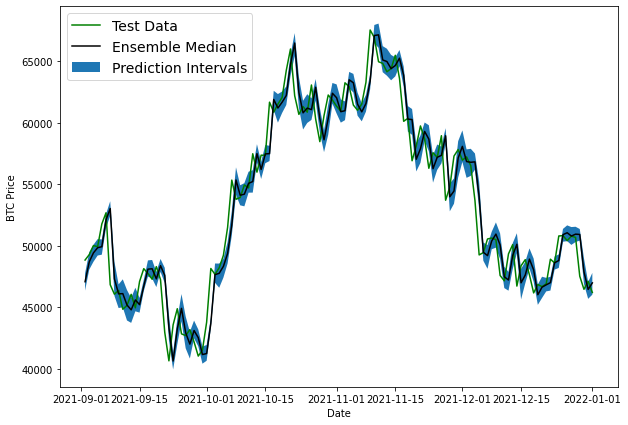

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=400
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

All our models are lagging, just like the naive model

> NOTE: These predicition intervals are estimates themselves and they've been created with the assumption that our model's data is from a normal distribution.

## Aside : Two types of uncertainity (coconut and subway)

Uncertainity estimates in machine learning seek out to qualitatively and quantitatively answer the questions:

1. What cna my model know? With perfect data, what's possible  for a model to learn.

2. What doens't my model know? What can a model never predict? Or would it be helpful if a model could tell you that when its correct or not.

There are two major types of uncertainity in machine learning you should know about. 

* **Aleatoric uncertainity** - this type of uncertainity cannot be reduced and it is often referred as "data" uncertainity or "subway" uncertainity.
* **Epistemic uncertainity** - this type of uncertainity can be reduced it is also referred to as "model" or "coconut" uncertainity. 

## Model 9 : TRain a model on full historic data to make predictions into the future.

So far all of our models have predicted on the test dataset, but this is only a pseudofuture.

Let's now build a model which is capable of prediting into the future.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

In [ ]:
# Make a copy
bitcoin_prices_windowed = bitcoin_prices.copy()

# Add windowed columsn
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price + {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)
bitcoin_prices_windowed.head(10)

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [ ]:
# Train model on entire data to make predictions for the next day
#X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis = 1).to_numpy()
# use the above representation if below line doesnt work
X_all = bitcoin_prices_windowed.dropna().drop(["Price"], axis = 1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"]
len(X_all) , len(y_all)

(2609, 2609)

In [ ]:
X_all[:5] ,y_all[:5]

(array([[357.239982, 344.745289, 341.459753, 348.99286 , 337.921358,
         328.644408, 324.467934],
        [371.116917, 357.239982, 344.745289, 341.459753, 348.99286 ,
         337.921358, 328.644408],
        [366.664633, 371.116917, 357.239982, 344.745289, 341.459753,
         348.99286 , 337.921358],
        [428.882925, 366.664633, 371.116917, 357.239982, 344.745289,
         341.459753, 348.99286 ],
        [418.944218, 428.882925, 366.664633, 371.116917, 357.239982,
         344.745289, 341.459753]]), Date
 2014-11-11    371.116917
 2014-11-12    366.664633
 2014-11-13    428.882925
 2014-11-14    418.944218
 2014-11-15    399.688315
 Name: Price, dtype: float64)

In [ ]:
# Tun data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
tf.random.set_seed(42)

from tensorflow.keras import layers

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the *future*

1. Takes as input:
  * a list of values
  * a trained model
  * a window into the future to predict `INTO_FUTURE` variable
  * the window size a model was trained on `WINDOW_SIZE` as the model can only predict on the kind of data it was trained on.
2. Creates an empty list for future forecasts (this will be returned at the end of the end, extract the last window from it)
3. Loop `INTO_FUTURE` times making a predicition on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction


In [ ]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """

  #2. create an empty list for future forecasts
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  #3. make INTO_FUTURE number of predictions, altering the data whicch gets preedicted on each
  for _ in range(into_future):
    # Predict the last window and append on it lelz
    future_pred = model.predict(tf.expand_dims(last_window,axis =0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predicitions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent pred
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast


In [ ]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
INTO_FUTURE = 14 
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 Date
2021-12-26    50430.073507
2021-12-27    50792.036921
2021-12-28    50696.802160
2021-12-29    47535.309698
2021-12-30    46471.230000
2021-12-31    47128.468155
2022-01-01    46208.210437
Name: Price, dtype: float64 -> Prediction: 51064.80078125

Predicting on: 
 [50792.036921   50696.80216    47535.309698   46471.23
 47128.468155   46208.210437   51064.80078125] -> Prediction: 50220.703125

Predicting on: 
 [50696.80216    47535.309698   46471.23       47128.468155
 46208.210437   51064.80078125 50220.703125  ] -> Prediction: 49372.61328125

Predicting on: 
 [47535.309698   46471.23       47128.468155   46208.210437
 51064.80078125 50220.703125   49372.61328125] -> Prediction: 46818.8203125

Predicting on: 
 [46471.23       47128.468155   46208.210437   51064.80078125
 50220.703125   49372.61328125 46818.8203125 ] -> Prediction: 47590.1796875

Predicting on: 
 [47128.468155   46208.210437   51064.80078125 50220.703125
 49372.61328125 46818.8203125  47590.1796875

### PLOT FUTURE FORECASTS

In [ ]:
future_forecast

[51064.8,
 50220.703,
 49372.613,
 46818.82,
 47590.18,
 47369.273,
 49064.492,
 50602.633,
 49752.645,
 48256.19,
 47508.56,
 48192.31,
 48692.3,
 50026.438]

In [ ]:
def get_future_dates(start_date, into_future, offset = 1):
  """
  Returns array of datetime values ranging from start_date till into_future
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype = "datetime64[D]")

In [ ]:
last_timestep = bitcoin_prices.index[-1]
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future = INTO_FUTURE)
next_time_steps

array(['2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
       '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09',
       '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
       '2022-01-14', '2022-01-15'], dtype='datetime64[D]')

In [ ]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

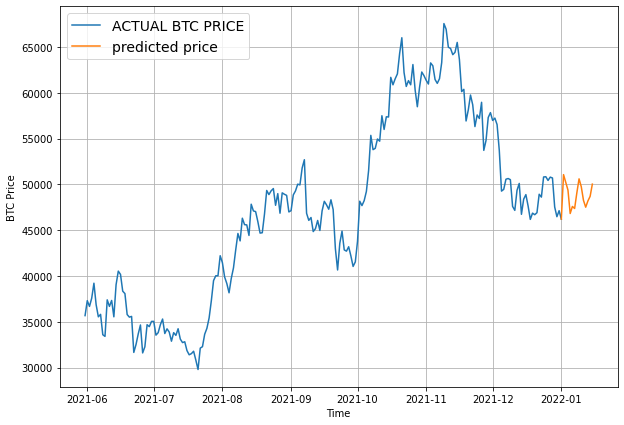

In [ ]:
# PLot future prices prediction of bitcoin
plt.figure(figsize = (10,7))
plot_time_series(bitcoin_prices.index, btc_price, start = 2400, format = "-", label= "ACTUAL BTC PRICE")
plot_time_series(next_time_steps, future_forecast, format = "-", label = "predicted price")

## MODEL 10: WHY FORECASTING IS BOLLOCKS

### The tukey problem

In [ ]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] /100

btc_price_turkey[-10:]

[48610.619112,
 50807.0,
 50834.3,
 50430.073507,
 50792.036921,
 50696.80216,
 47535.309698,
 46471.23,
 47128.468155,
 462.08210437]

In [ ]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-12-23T00:00:00.000000000', '2021-12-24T00:00:00.000000000',
       '2021-12-25T00:00:00.000000000', '2021-12-26T00:00:00.000000000',
       '2021-12-27T00:00:00.000000000', '2021-12-28T00:00:00.000000000',
       '2021-12-29T00:00:00.000000000', '2021-12-30T00:00:00.000000000',
       '2021-12-31T00:00:00.000000000', '2022-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

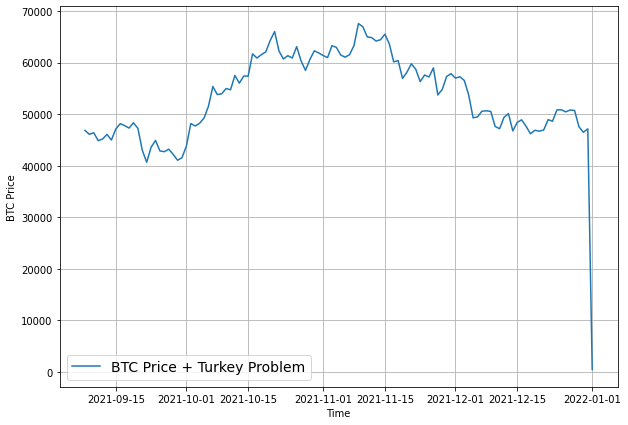

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2087, 522, 2087, 522)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets
INFO:tensorflow:Assets written to: model_experiment

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)


17/17 [==============================] - 0s 2ms/step - loss: 1214.8180


1214.8179931640625

In [ ]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 1190.2650


1190.2650146484375

In [ ]:
turkey_preds = make_preds(turkey_model, X_test)
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                y_pred=turkey_preds)
turkey_results

{'mae': 1190.2653,
 'mape': 22.092985,
 'mase': 0.99624926,
 'mse': 6808325.0,
 'rmse': 2609.2766}